In [1]:
from qiskit_aer import Aer
from scripts.algo.iterative_phase_estimation import iterative_phase_estimation_v2
from scripts.algo.chebyshev import chebyshev_nodes, chebyshev_barycentric_interp_point
import scipy
import numpy as np
from qiskit_algorithms import NumPyEigensolver
from scripts.algo.qdrift import QDrift
from scripts.database import *

In [2]:
import os, sys
# To suppress the prints from Iterative Phase Estimation function
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [3]:
import matplotlib.pyplot as plt
def draw_plot(axs, idx, title:str, x:list[float], x_label:str, y:list[float], y_label:str):
    "Draw the subplot of title with the x-axis and the y-axis labeled as x-label and y-axis relatively."
    axs[idx[0], idx[1]].plot(x, y)
    axs[idx[0], idx[1]].set_xlabel(x_label)
    axs[idx[0], idx[1]].set_ylabel(y_label)
    axs[idx[0], idx[1]].set_title(title)

In [12]:
def extrapolation(t, ld: Hamiltonian, num_eval, num_qubit):
    selected_backend = Aer.get_backend('qasm_simulator') # Simulation backend from qiskit
    
    fig, axs = plt.subplots(2, 2) # Figure
    fig.set_figheight(10)
    fig.set_figwidth(10)
    domain = np.linspace(-1, 1, 200) # Domain for extrapolation
    axs_x = 0
    axs_y = 0  
    
    decomp = ld.get_decomp()
    whole = np.sum([tensor.coefficient * tensor.matrix for tensor in decomp.lst_Hamil], 0)
    print(whole)
    lm = ld.get_decomp().sum_abs_coeff
    exact_eigenvalue, eigenvectors = scipy.linalg.eig(whole)
    expected = min(exact_eigenvalue) # Get the minimum eigenvalue of the hamiltonian
    
    oracle = QDrift(ld, t)
    
    for n in range(2, 10, 2):  # number of the Chebyshev nodes
        data_point = [] # Storage for data points to be interpolated
        nodes = chebyshev_nodes(n) # The n Chebyshev nodes
        
        for node in nodes:
            estimations = [] # Storage for each eigenvalue estimation of individual unitary 
            N = np.ceil(np.abs(t / node)) # number of samplings
            h_list, v_list = oracle.qdrift(N)
            
            for i in range(len(h_list)):
                exact_eigenvalue, eigenvectors = scipy.linalg.eig(h_list[i]) # Get eigenvectors and values for each unitary
                eigenstate = eigenvectors[:, np.argmin(exact_eigenvalue)] # pick eigenstate that corresponds to smallest eigenvalue
                with HiddenPrints(): # Do Iterative Phase Estimation
                    p_0, qc = iterative_phase_estimation_v2(v_list[i], num_eval, eigenstate, selected_backend, num_qubits=num_qubit)
                estimated_eigenvalue = 2 * np.arccos(np.sqrt(p_0)) # Estimate eigenvalue
                if min(exact_eigenvalue) < 0:
                    estimated_eigenvalue *= -1
                estimations.append(N * estimated_eigenvalue / lm / t)
            data_point.append(np.average(estimations)) # Average out the estimations
            
        # plot
        draw_plot(axs, (axs_x, axs_y), f'Extrapolation with {len(nodes)} Chebyshev nodes', domain, 'x', [chebyshev_barycentric_interp_point(x, n, data_point) for x in domain], 'estimation')
        axs[axs_x, axs_y].plot(nodes, data_point, 'bo')
        axs[axs_x, axs_y].axhline(expected, color='r', linestyle='--')
        axs_x = (axs_x + axs_y) % 2
        axs_y = (axs_y + 1) % 2
        print("generated")

Data loaded from ../data\hubbard/h_2.pkl
[[2. 1.]
 [1. 2.]]
generated
generated
generated
generated


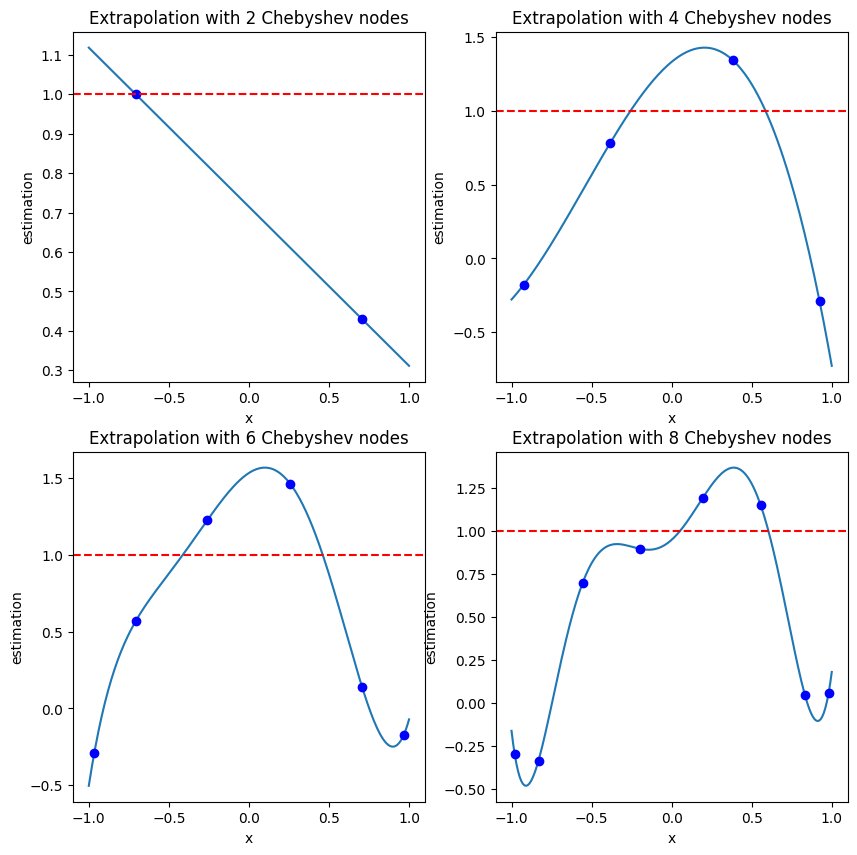

In [13]:
data = DataManager("../data")  # Create DataManager instance
ld = data.load('hubbard', "h_2") # load the hubbard model
ld.decompose(-1, 2) # t = +1 and u = +2

extrapolation(10, ld, 1000, 1)

[[2. 1. 0. 0.]
 [1. 2. 1. 0.]
 [0. 1. 2. 1.]
 [0. 0. 1. 2.]]


KeyboardInterrupt: 

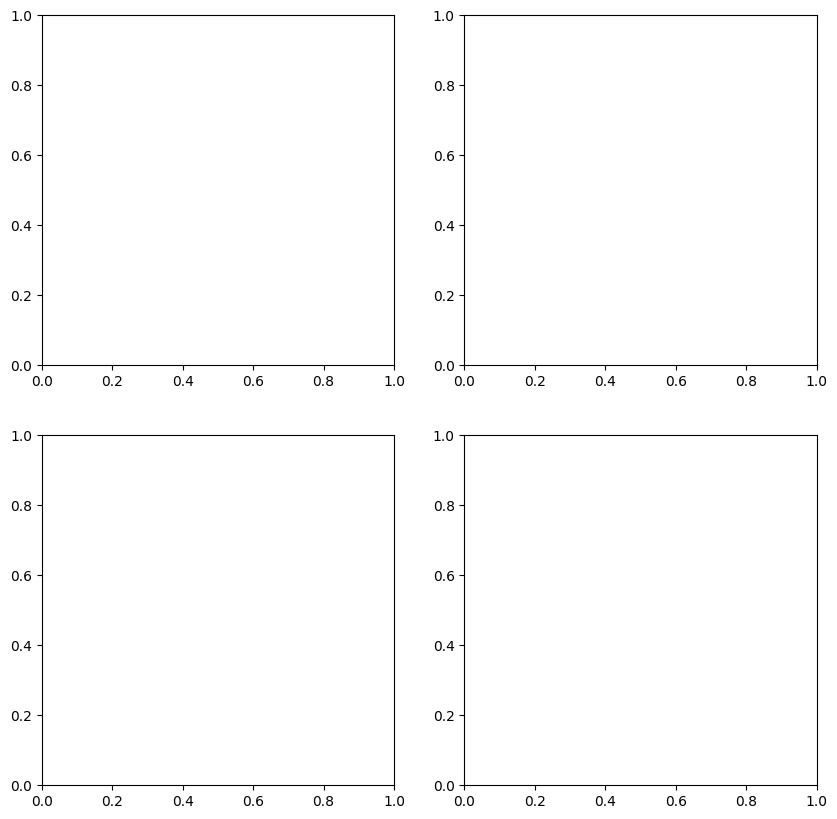

In [15]:
ld = Hubbard(4)
ld.decompose(-1,2)

extrapolation(100, ld, 1000, 2)